/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


(402, 7)
   USE     RS        RS_ALT           GEN     SHAPE_LENG    SHAPE_AREA  \
0    4  01001  010010000000     Flensburg   32467.034276  5.324899e+07   
1    4  01002  010020000000          Kiel   73027.302434  1.218654e+08   
2    4  01003  010030000000        Lübeck  104861.094220  2.211386e+08   
3    4  01004  010040000000    Neumünster   39858.818376  8.092363e+07   
4    4  01051  010510000000  Dithmarschen  202206.675707  1.450311e+09   

                                            geometry  
0  POLYGON ((9.48982 54.82296, 9.50467 54.81004, ...  
1  POLYGON ((10.19057 54.38909, 10.18370 54.38910...  
2  POLYGON ((10.89297 53.95695, 10.90337 53.95705...  
3  POLYGON ((10.03454 54.12915, 10.02277 54.10938...  
4  MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3...  


<AxesSubplot:>

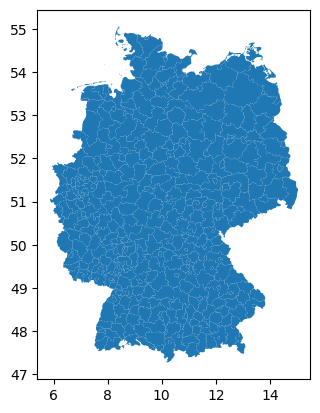

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
import geopandas as gpd
import collections
from PythonFiles.model import model,preprocessing
from PythonFiles.Configuration import Configuration
config = Configuration()
df = gpd.read_file('vg2500_krs.shp')
df = df.set_geometry('geometry')

print(df.shape)
print(df.head())  
df.plot()

## Determine the neighbors and the resulting adjacent matrix based on the Shapefile

In [2]:
for index, row in df.iterrows():  
    neighbors = list(df[(df.geometry.touches(row['geometry'])) | (df.geometry.overlaps(row['geometry']))].GEN) 
    if row.GEN in neighbors:   
        neighbors = neighbors.remove(row.GEN)
    if neighbors is not None:
        df.at[index, "my_neighbors"] = neighbors#", ".join(neighbors)
    #else: 
     #   print(f"NONE für {row.location}")
#print(neighbors)

df['my_neighbors'] = df['my_neighbors'].fillna("nan")
#df.loc[df.my_neighbors == "nan",'my_neighbors'] = ['nan']
print(list(df.my_neighbors))

['Schleswig-Flensburg', ['Plön', 'Rendsburg-Eckernförde'], ['Herzogtum Lauenburg', 'Ostholstein', 'Stormarn', 'Nordwestmecklenburg'], ['Plön', 'Rendsburg-Eckernförde', 'Segeberg'], ['Nordfriesland', 'Rendsburg-Eckernförde', 'Schleswig-Flensburg', 'Steinburg', 'Stade'], ['Lübeck', 'Stormarn', 'Hamburg', 'Harburg', 'Lüneburg', 'Ludwigslust-Parchim', 'Nordwestmecklenburg'], ['Dithmarschen', 'Schleswig-Flensburg'], ['Lübeck', 'Plön', 'Segeberg', 'Stormarn'], ['Kiel', 'Neumünster', 'Ostholstein', 'Rendsburg-Eckernförde', 'Segeberg'], ['Kiel', 'Neumünster', 'Dithmarschen', 'Plön', 'Schleswig-Flensburg', 'Segeberg', 'Steinburg'], ['Flensburg', 'Dithmarschen', 'Nordfriesland', 'Rendsburg-Eckernförde'], ['Neumünster', 'Ostholstein', 'Plön', 'Rendsburg-Eckernförde', 'Steinburg', 'Stormarn', 'Hamburg', 'Pinneberg'], ['Dithmarschen', 'Rendsburg-Eckernförde', 'Segeberg', 'Pinneberg', 'Stade'], ['Lübeck', 'Herzogtum Lauenburg', 'Ostholstein', 'Segeberg', 'Hamburg'], ['Herzogtum Lauenburg', 'Segeberg

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'colu

ValueError: cannot convert float NaN to integer

<Figure size 1000x700 with 1 Axes>

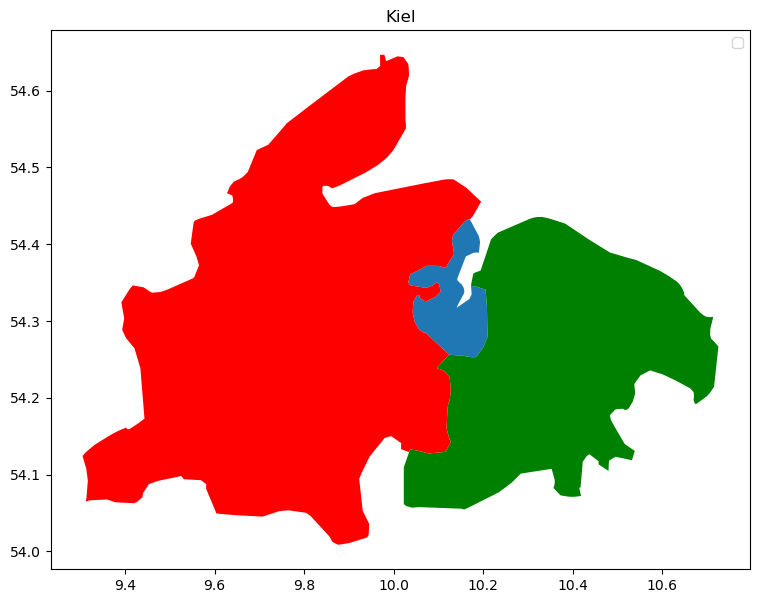

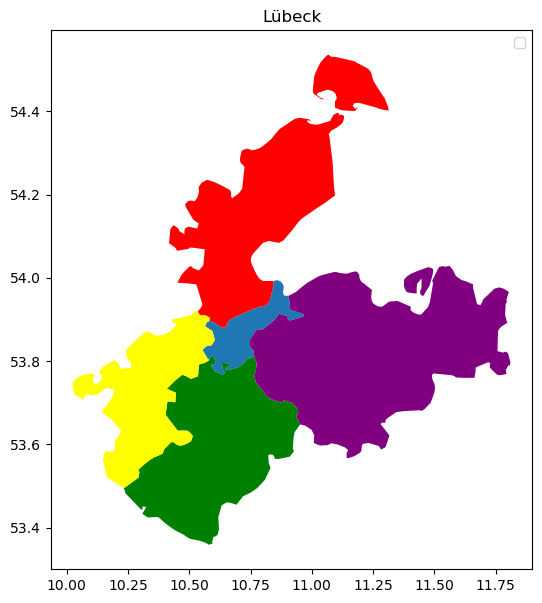

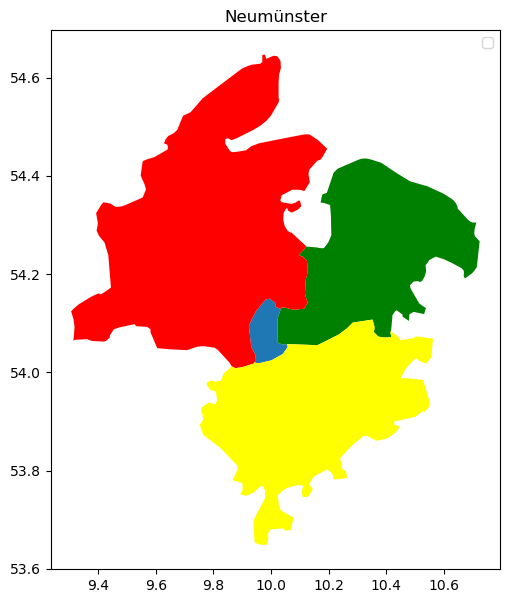

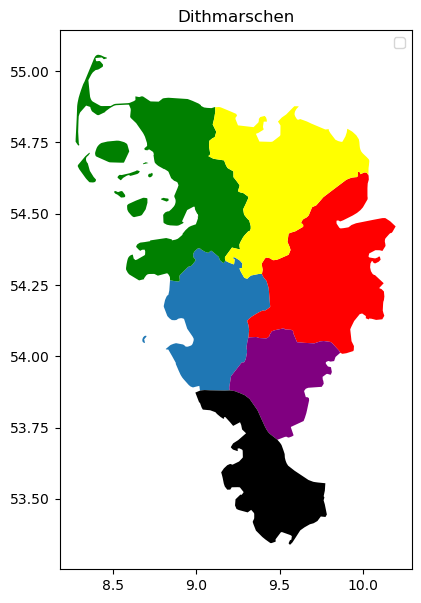

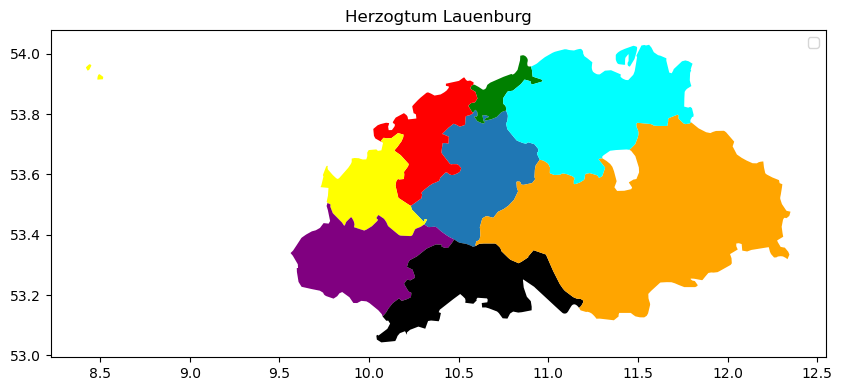

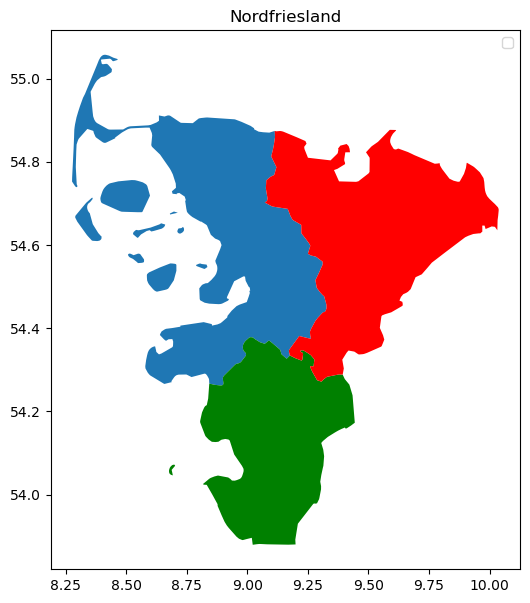

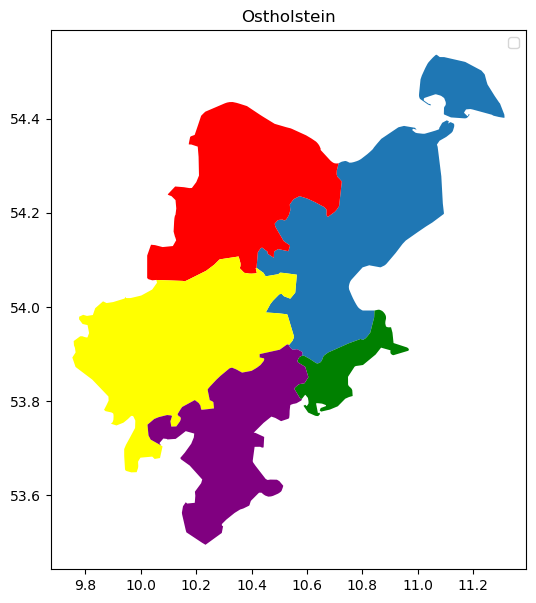

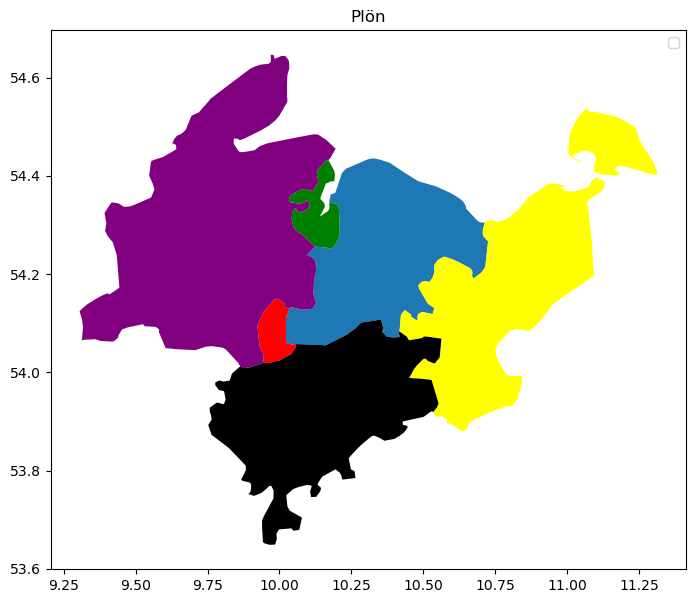

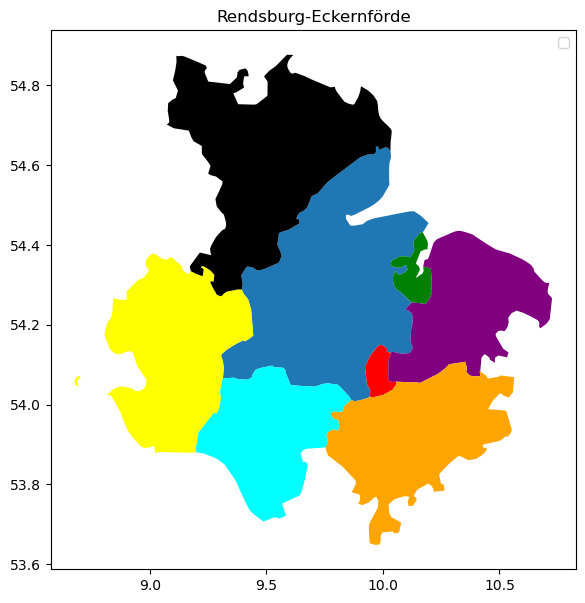

In [3]:
colors = ["green", "red", "yellow" , "purple", "black", "orange", "cyan", "magenta", "grey"]*2
for location in df.GEN.unique()[:10]:
    location_df = df.loc[df.GEN == location].copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    location_df.plot(ax=ax)
    plt.title(f"{location}")
    neighbors = list(location_df["my_neighbors"])
    if len(neighbors) >0:
        for neighbor in neighbors:
            neighbor_df = df.loc[df.GEN.isin(list(neighbor))].copy()
            neighbor_df.plot(neighbor_df, ax=ax, color=colors, legend=True)
    plt.legend()
plt.show()

In [4]:
matrix_df = pd.DataFrame(columns=df.GEN.unique(), index=df.GEN.unique())
for location1 in df.GEN.unique():
    location_df = df.loc[df.GEN == location1].copy()
    neighbors = list(location_df["my_neighbors"])
    if len(neighbors)>0:
        #print(location1)
        #print(neighbors)
        for neighbor in neighbors[0]:
            matrix_df.loc[location1, neighbor] = 1
            matrix_df.loc[neighbor, location1] = 1
            matrix_df.loc[location1, location1] = 0
    else:
        print(location1)
matrix_df = matrix_df.fillna(0)
print(matrix_df)
print(matrix_df.isna().sum())
print(len(df.GEN.unique()))

              Flensburg  Kiel  Lübeck  Neumünster  Dithmarschen  \
Flensburg             0     0       0           0             0   
Kiel                  0     0       0           0             0   
Lübeck                0     0       0           0             0   
Neumünster            0     0       0           0             0   
Dithmarschen          0     0       0           0             0   
...                 ...   ...     ...         ...           ...   
n                     1     0       0           0             0   
b                     1     0       0           0             0   
u                     1     0       0           0             0   
r                     1     0       0           0             0   
a                     0     0       0           0             0   

              Herzogtum Lauenburg  Nordfriesland  Ostholstein  Plön  \
Flensburg                       0              0            0     0   
Kiel                            0              0     

In [5]:
matrix_df.to_csv("AdjacentMatrix.csv")

## Compare the names in Influenza.csv to the names in the Shapefile

In [6]:
influenza_df = pd.read_csv("Influenza.csv", sep=',')
locations = influenza_df.location.unique()

In [8]:
names = list(df.GEN.unique())
renaming_dict = dict()
# Iterate over the names defined by the Shapefile
for name in names:
    renaming_dict[name] = []
    # then iterate over the locations names defined by the influenza.csv file
    for location in locations:
        # filter out the names, where the Shapefile-Name String is part of the Influenza-File-Name String, and save them to the dict
        if name in location:
            renaming_dict[name].append(location) 
for key in config.specific_matches.keys():
    if key in list(renaming_dict.keys()):
        renaming_dict[key] = config.specific_matches[key]

### The following LK and SK weren't renamed properly

In [9]:
# select the values where we either have more than one match of strings or no matching string at all...
not_matching_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if ((len(v)==0) | (len(v)>1))}
print(print(collections.OrderedDict(sorted(not_matching_dict.items()))))
print(len(not_matching_dict))

OrderedDict([('Ansbach', ['LK Ansbach', 'SK Ansbach']), ('Aschaffenburg', ['LK Aschaffenburg', 'SK Aschaffenburg']), ('Augsburg', ['LK Augsburg', 'SK Augsburg']), ('Bamberg', ['LK Bamberg', 'SK Bamberg']), ('Bayreuth', ['SK Bayreuth', 'LK Bayreuth']), ('Berlin', ['SK Berlin Charlottenburg-Wilmersdorf', 'SK Berlin Friedrichshain-Kreuzberg', 'SK Berlin Lichtenberg', 'SK Berlin Marzahn-Hellersdorf', 'SK Berlin Mitte', 'SK Berlin Neukölln', 'SK Berlin Pankow', 'SK Berlin Reinickendorf', 'SK Berlin Spandau', 'SK Berlin Steglitz-Zehlendorf', 'SK Berlin Tempelhof-Schöneberg', 'SK Berlin Treptow-Köpenick']), ('Coburg', ['LK Coburg', 'SK Coburg']), ('Eisenach', []), ('Fürth', ['LK Fürth', 'SK Fürth']), ('Heilbronn', ['LK Heilbronn', 'SK Heilbronn']), ('Hof', ['LK Hof', 'SK Hof']), ('Kaiserslautern', ['LK Kaiserslautern', 'SK Kaiserslautern']), ('Karlsruhe', ['LK Karlsruhe', 'SK Karlsruhe']), ('Kassel', ['LK Kassel', 'SK Kassel']), ('Landshut', ['LK Landshut', 'SK Landshut']), ('Leipzig', ['LK L

In [10]:
# Additionally it makes sense to check manually, if the remaining matching keys and values are correctly matched
correctly_matched_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if len(v) == 1}
print(collections.OrderedDict(sorted(correctly_matched_dict.items())))
len(correctly_matched_dict)

OrderedDict([('Aachen', ['StädteRegion Aachen']), ('Ahrweiler', ['LK Ahrweiler']), ('Aichach-Friedberg', ['LK Aichach-Friedberg']), ('Alb-Donau-Kreis', ['LK Alb-Donau-Kreis']), ('Altenburger Land', ['LK Altenburger Land']), ('Altenkirchen (Westerwald)', ['LK Altenkirchen']), ('Altmarkkreis Salzwedel', ['LK Altmarkkreis Salzwedel']), ('Altötting', ['LK Altötting']), ('Alzey-Worms', ['LK Alzey-Worms']), ('Amberg', ['SK Amberg']), ('Amberg-Sulzbach', ['LK Amberg-Sulzbach']), ('Ammerland', ['LK Ammerland']), ('Anhalt-Bitterfeld', ['LK Anhalt-Bitterfeld']), ('Aurich', ['LK Aurich']), ('Bad Dürkheim', ['LK Bad Dürkheim']), ('Bad Kissingen', ['LK Bad Kissingen']), ('Bad Kreuznach', ['LK Bad Kreuznach']), ('Bad Tölz-Wolfratshausen', ['LK Bad Tölz-Wolfratshausen']), ('Baden-Baden', ['SK Baden-Baden']), ('Barnim', ['LK Barnim']), ('Bautzen', ['LK Bautzen']), ('Berchtesgadener Land', ['LK Berchtesgadener Land']), ('Bergstraße', ['LK Bergstraße']), ('Bernkastel-Wittlich', ['LK Bernkastel-Wittlich'

351

In [11]:
# also determine possible missing matched locations from the influenza.csv locations
#print(list(correctly_matched_dict.values()))
remaining_loc = [location for location in locations if location not in [location[0] for location in correctly_matched_dict.values()]]
print(remaining_loc)

['LK Ansbach', 'LK Bamberg', 'LK Coburg', 'LK Heilbronn', 'LK Karlsruhe', 'LK Kassel', 'LK Landshut', 'LK Leipzig', 'LK München', 'LK Offenbach', 'LK Osnabrück', 'LK Rosenheim', 'LK Rostock', 'LK Schweinfurt', 'LK Würzburg', 'SK Bamberg', 'SK Bayreuth', 'SK Berlin Charlottenburg-Wilmersdorf', 'SK Berlin Friedrichshain-Kreuzberg', 'SK Berlin Lichtenberg', 'SK Berlin Marzahn-Hellersdorf', 'SK Berlin Mitte', 'SK Berlin Neukölln', 'SK Berlin Pankow', 'SK Berlin Reinickendorf', 'SK Berlin Spandau', 'SK Berlin Steglitz-Zehlendorf', 'SK Berlin Tempelhof-Schöneberg', 'SK Berlin Treptow-Köpenick', 'SK Coburg', 'SK Karlsruhe', 'SK Kassel', 'SK Landshut', 'SK Leipzig', 'SK München', 'SK Offenbach', 'SK Osnabrück', 'SK Schweinfurt', 'SK Würzburg', 'LK Aschaffenburg', 'LK Augsburg', 'LK Bayreuth', 'LK Fürth', 'LK Hof', 'LK Passau', 'LK Regensburg', 'SK Augsburg', 'SK Fürth', 'SK Heilbronn', 'SK Hof', 'SK Oldenburg', 'SK Regensburg', 'SK Rosenheim', 'SK Rostock', 'LK Kaiserslautern', 'LK Oldenburg',

### identification of locations that are doubles in the geodata

In [28]:
#print(df[df.GEN.isin(list(not_matching_dict.keys()))])
for name in not_matching_dict.keys():
    doubled_df = df[df.GEN == name].copy()
    if len(doubled_df)>1:
        doubled_df.loc[doubled_df['SHAPE_LENG'] == min(doubled_df['SHAPE_LENG']),"GEN"] = f"SK {name}"
        doubled_df.loc[doubled_df['SHAPE_LENG'] == max(doubled_df['SHAPE_LENG']),"GEN"] = f"LK {name}"
        print(doubled_df)

    USE     RS        RS_ALT           GEN     SHAPE_LENG    SHAPE_AREA  \
48    4  03404  034040000000  SK Osnabrück   54919.713644  1.215489e+08   
58    4  03459  034590000000  LK Osnabrück  317921.769620  2.109330e+09   

                                             geometry my_neighbors  
48  POLYGON ((7.95551 52.27194, 7.93298 52.28839, ...          nan  
58  POLYGON ((7.90848 52.68259, 7.91802 52.67965, ...          nan  
     USE     RS        RS_ALT        GEN     SHAPE_LENG    SHAPE_AREA  \
136    4  06611  066110000000  SK Kassel   42943.103665  1.128312e+08   
139    4  06633  066330000000  LK Kassel  270032.433256  1.269163e+09   

                                              geometry my_neighbors  
136  POLYGON ((9.55656 51.35201, 9.56802 51.33930, ...          nan  
139  POLYGON ((9.68499 51.58263, 9.67246 51.56870, ...          nan  
     USE     RS        RS_ALT                GEN     SHAPE_LENG    SHAPE_AREA  \
160    4  07312  073120000000  SK Kaiserslautern   60164

[['Potsdam', 'Barnim', 'Dahme-Spreewald', 'Havelland', 'Märkisch-Oderland', 'Oberhavel', 'Oder-Spree', 'Potsdam-Mittelmark', 'Teltow-Fläming']]


<AxesSubplot:>

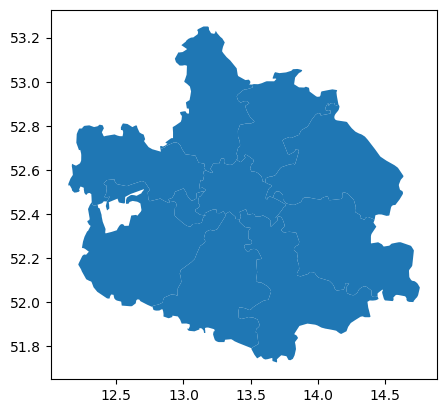

In [42]:
print(list(df[df.GEN.isin(["Berlin",""])].my_neighbors))
df[df.GEN.isin(["Berlin",'Potsdam', 'Barnim', 'Dahme-Spreewald', 'Havelland', 'Märkisch-Oderland', 'Oberhavel', 'Oder-Spree', 'Potsdam-Mittelmark', 'Teltow-Fläming'])].plot()

## Lastly rename the columns and rows of the Adjacency matrix to match the influenza.csv file